### 1. import all necessary libraries

In [2]:
import cv2
import os
import sys
import math
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from os.path import splitext, basename
from keras.utils import to_categorical
from keras.models import model_from_json
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
ROOT_DIR = os.path.abspath("")
path_funcs = ROOT_DIR+"\\resources" # notice the double backwards slash, else it won't work
sys.path.append(path_funcs)  # To find local version
from funcs import detect_lp

### 2. Import WPOD model to preprocess images

In [3]:
# Local path to wpod-net
# WPOD-Net stands fpr "Warped Planar Object Detection Network"
# Paper at: https://www.ecva.net/papers/eccv_2018/papers_ECCV/papers/Sergio_Silva_License_Plate_Detection_ECCV_2018_paper.pdf
wj_path = os.path.join(path_funcs, "wpod-net.json")

def load_model(path):
    try:
        with open(wj_path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s\wpod-net.h5' % path)
        print("Loaded model with weights.")
        return model
    except Exception as e:
        print(":(\n",e)
        
wpod_net = load_model(path_funcs)

Loaded model with weights.


### 3. Preprocess images

In [4]:
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path) # reads the parsing image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # converts it to RGB
    img = img / 255 # normalizes the image data to 0–1 range
    if resize:
# set resize = True to resize all images to same dimension of (width = 224, height = 224)
        img = cv2.resize(img, (224,224)) 
    return img

Found 44 images...


c:\users\dxoco\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


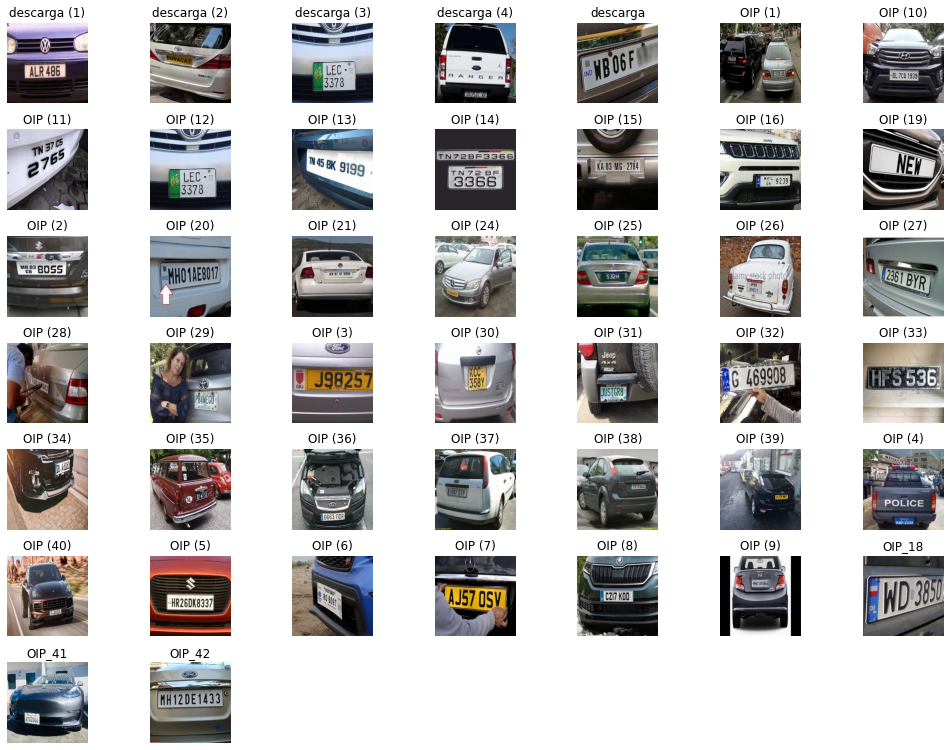

In [5]:
# Create a list of image paths and visualize images in subplot
image_paths = glob.glob("plate_numbers/*.jpg")
print("Found %i images..."%(len(image_paths)))

# Visualize data
cols = math.ceil(np.sqrt(len(image_paths)))
rows = cols
fig = plt.figure(figsize=(cols*2,rows*1.5))

fig_list = []
for i in range(len(image_paths)):
    fig_list.append(fig.add_subplot(rows,cols,i+1))
    title = splitext(basename(image_paths[i]))[0]
    fig_list[-1].set_title(title)
    img = preprocess_image(image_paths[i],True)
    plt.axis(False)
    plt.imshow(img)

plt.tight_layout(True)
plt.show()

In [6]:
#![title](resources/images/cochecitos.png)

### 4. Identifing license plates

In [7]:
def get_plate(image_path, Dmax=3500, Dmin=150):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return LpImg, cor

In [9]:
###### Obtain plate crop and its coordinates from a complete image
for i in range(len(image_paths)):
    try:
        test_image = image_paths[i]
        LpImg,cor = get_plate(test_image)
        print("Detect %i plate in"%len(LpImg),splitext(basename(test_image))[0])
    except:
        print("error at %i"%len(LpImg),splitext(basename(test_image))[0])
        pass
# print("Coordinate of plate(s) in image: \n", cor)

Detect 1 plate in descarga (1)
Detect 1 plate in descarga (2)
Detect 1 plate in descarga (3)
Detect 1 plate in descarga (4)
Detect 1 plate in descarga
Detect 2 plate in OIP (1)
Detect 1 plate in OIP (10)
Detect 1 plate in OIP (11)
Detect 1 plate in OIP (12)
Detect 1 plate in OIP (13)
Detect 1 plate in OIP (14)
Detect 1 plate in OIP (15)
Detect 1 plate in OIP (16)
Detect 1 plate in OIP (19)
Detect 1 plate in OIP (2)
Detect 1 plate in OIP (20)
Detect 1 plate in OIP (21)
Detect 1 plate in OIP (24)
Detect 1 plate in OIP (25)
Detect 1 plate in OIP (26)
Detect 1 plate in OIP (27)
Detect 1 plate in OIP (28)
Detect 1 plate in OIP (29)
Detect 1 plate in OIP (3)
Detect 1 plate in OIP (30)
Detect 1 plate in OIP (31)
Detect 1 plate in OIP (32)
Detect 1 plate in OIP (33)
Detect 2 plate in OIP (34)
Detect 1 plate in OIP (35)
Detect 1 plate in OIP (36)
Detect 1 plate in OIP (37)
Detect 1 plate in OIP (38)
Detect 1 plate in OIP (39)
Detect 1 plate in OIP (4)
Detect 1 plate in OIP (40)
Detect 1 plate i

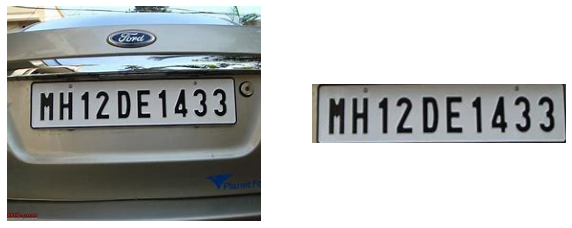

In [10]:
# Visualize our result

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.axis(False)
plt.imshow(preprocess_image(test_image))
plt.subplot(1,2,2)
plt.axis(False)
plt.imshow(LpImg[0])

In [9]:
#![title](resources/images/big_and_roi.png)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


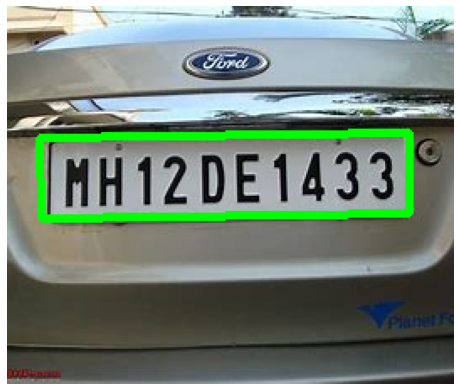

In [11]:
def draw_box(image_path, cor, thickness=3): 
    pts=[]  
    x_coordinates=cor[0][0]
    y_coordinates=cor[0][1]
    # store the top-left, top-right, bottom-left, bottom-right 
    # of the plate license respectively
    for i in range(4):
        pts.append([int(x_coordinates[i]),int(y_coordinates[i])])
    
    pts = np.array(pts, np.int32)
    pts = pts.reshape((-1,1,2))
    vehicle_image = preprocess_image(image_path)
    
    cv2.polylines(vehicle_image,[pts],True,(0,255,0),thickness)
    return vehicle_image

plt.figure(figsize=(8,8))
plt.axis(False)
plt.imshow(draw_box(test_image,cor))

In [12]:
#![title](resources/images/ROI_verde.png)

c:\users\dxoco\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


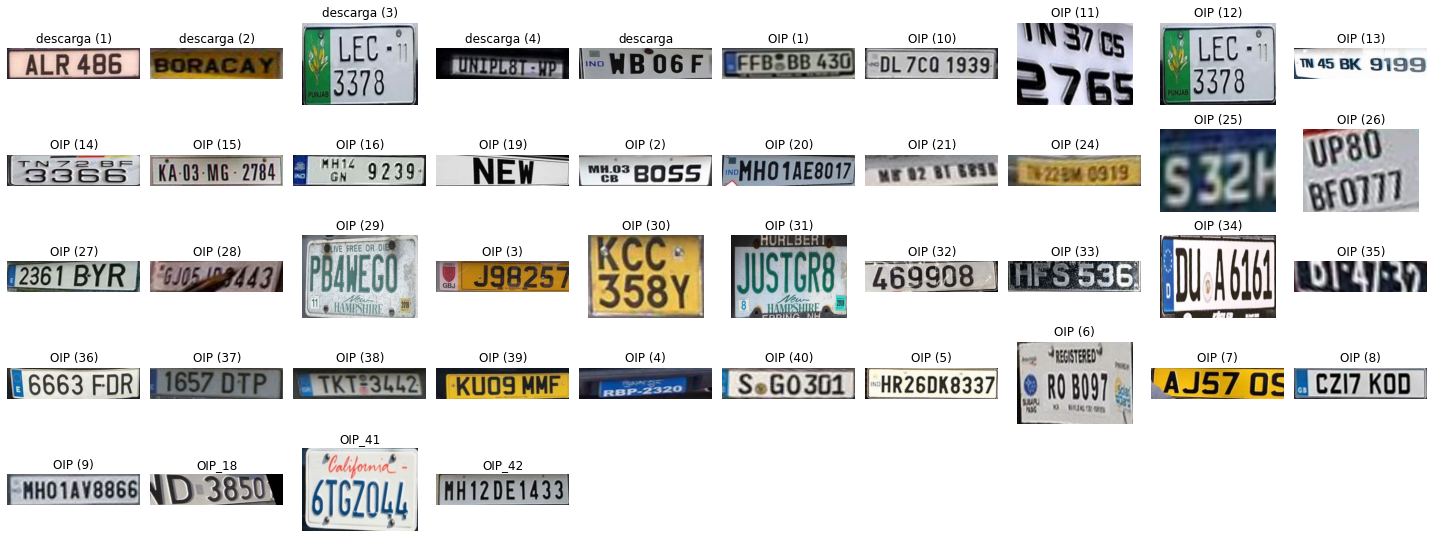

In [37]:
# Viualize all obtained plate images 

fig_list = []
plaquitas_list = []
fig = plt.figure(figsize=(cols*2,rows*1.5))
for i in range(len(image_paths)):
    try:
        fig_list.append(fig.add_subplot(rows,cols,i+1))
        title = splitext(basename(image_paths[i]))[0]
        fig_list[-1].set_title(title)
        LpImg,_ = get_plate(image_paths[i])
        plaquitas_list.append(LpImg)
        plt.axis(False)
        plt.imshow(LpImg[0])
    except:
        pass

plt.tight_layout(True)
plt.show()

### 5. Identify characters in lp

In [14]:
#![title](resources/images/plaquitas.png)

In [15]:
if (len(LpImg)): #check if there is at least one license image
    # python considers any number greater tahn 0 as a true~ish value, thus no need to put >=
    # Scales, calculates absolute values, and converts the result to 8-bit.
    plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))
    
    # convert to grayscale and blur the image
    gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    # Blur technique is performed to remove noise
    blur = cv2.GaussianBlur(gray,(5,5),0)
    
    # Applied inversed thresh_binary 
    binary = cv2.threshold(blur, 100, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    ## Applied dilation to increase the white region of the image
    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)

Detected 10 letters...


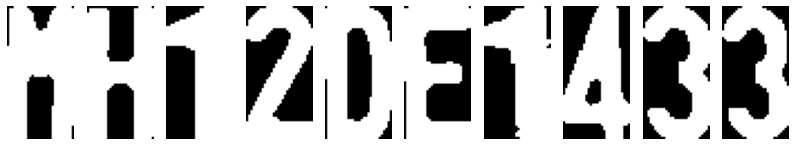

In [16]:
# Create sort_contours() function to grab the contour of each digit from left to right
def sort_contours(cnts,reverse = False):
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts

cont, _  = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# creat a copy version "test_roi" of plat_image to draw bounding box
test_roi = plate_image.copy()

# Initialize a list which will be used to append charater image
crop_characters = []

# define standard width and height of character
digit_w, digit_h = 30, 60

for c in sort_contours(cont):
    (x, y, w, h) = cv2.boundingRect(c)
    ratio = h/w
    if 1<=ratio<=4.5: # Only select contour with defined ratio

        if h/plate_image.shape[0]>=0.5: # Select contour which has the height larger than 50% of the plate
            # Draw bounding box arroung digit number
            cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)

            # Seperate number and give prediction
            curr_num = thre_mor[y:y+h,x:x+w]
            curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
            _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            crop_characters.append(curr_num)

print("Detected {} letters...".format(len(crop_characters)))  

fig = plt.figure(figsize=(14,4))
grid = gridspec.GridSpec(ncols=len(crop_characters),nrows=1,figure=fig)

for i in range(len(crop_characters)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.imshow(crop_characters[i],cmap="gray")

In [17]:
#![title](resources/images/pre_label.png)

### 6. Training phase

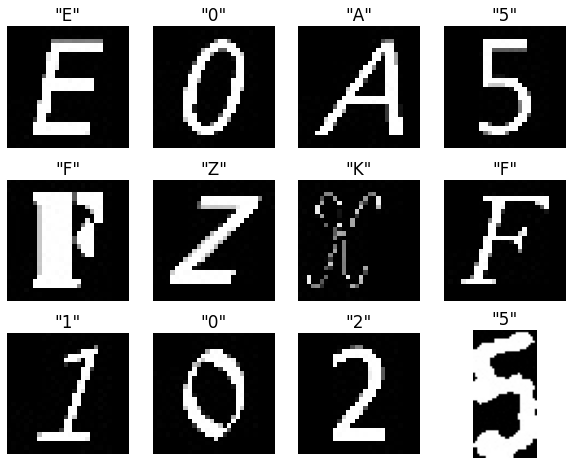

In [17]:
# reading the dataset for the CNN
dataset_paths = glob.glob("resources/dataset_characters/**/*.jpg")

cols=4
rows=3
fig = plt.figure(figsize=(10,8))
plt.rcParams.update({"font.size":14})
grid = gridspec.GridSpec(ncols=cols,nrows=rows,figure=fig)

# create a random list of images will be displayed
np.random.seed(42)
rand = np.random.randint(0,len(dataset_paths),size=(cols*rows))

# Plot example images
for i in range(cols*rows):
    fig.add_subplot(grid[i])
    image = load_img(dataset_paths[rand[i]])
    label = dataset_paths[rand[i]].split(os.path.sep)[-2]
    plt.title('"{:s}"'.format(label))
    plt.axis(False)
    plt.imshow(image)

In [18]:
#![title](resources/images/letras_4x3.png)

In [19]:
# Arrange input data and corresponding labels
X=[]
labels=[]

for image_path in dataset_paths:
    label = image_path.split(os.path.sep)[-2]
    image=load_img(image_path,target_size=(80,80))
    image=img_to_array(image)

    X.append(image)
    labels.append(label)

X = np.array(X,dtype="float16")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelEncoder()
lb.fit(labels)
labels = lb.transform(labels)
y = to_categorical(labels)

# save label file
np.save('license_character_classes.npy', lb.classes_)

# split 10% of data as validation set
(trainX, testX, trainY, testY) = train_test_split(X, y, test_size=0.10, stratify=y, random_state=42)


# generate data augumentation method
image_gen = ImageDataGenerator(rotation_range=10,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              zoom_range=0.1,
                              fill_mode="nearest"
                              )

print("[INFO] Found {:d} images with {:d} classes".format(len(X),len(set(labels))))

[INFO] Found 37623 images with 36 classes


### 7. Convolutional Neural Network to identify individual characters A-Z, 0-9

In [23]:
pf_img_rec_model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(160, (3, 3), input_shape=(80, 80, 3)),
    tf.keras.layers.Conv2D(160, (3, 3),  activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.05),
    # The second convolution
    tf.keras.layers.Conv2D(256, (3, 3),  activation='relu'),
    tf.keras.layers.Conv2D(256, (3, 3),  activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 128 neuron hidden layer
    tf.keras.layers.Dense(160, activation='relu'),
    tf.keras.layers.Dense(36, activation='softmax')
])

In [24]:
pf_img_rec_model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
pf_img_rec_model_hist = pf_img_rec_model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=64, epochs=20, verbose=1)

Epoch 1/20
530/530 [==============================] - 216s 407ms/step - loss: 0.6552 - accuracy: 0.8457 - val_loss: 0.5617 - val_accuracy: 0.8669
Epoch 2/20
530/530 [==============================] - 210s 397ms/step - loss: 0.3134 - accuracy: 0.9159 - val_loss: 0.3918 - val_accuracy: 0.9043
Epoch 3/20
530/530 [==============================] - 210s 397ms/step - loss: 0.1986 - accuracy: 0.9427 - val_loss: 0.3160 - val_accuracy: 0.9290
Epoch 4/20
530/530 [==============================] - 210s 397ms/step - loss: 0.1573 - accuracy: 0.9521 - val_loss: 0.2272 - val_accuracy: 0.9397
Epoch 5/20
530/530 [==============================] - 210s 397ms/step - loss: 0.1014 - accuracy: 0.9692 - val_loss: 0.2792 - val_accuracy: 0.9378
Epoch 6/20
530/530 [==============================] - 211s 397ms/step - loss: 0.0890 - accuracy: 0.9711 - val_loss: 0.3384 - val_accuracy: 0.9338
Epoch 7/20
530/530 [==============================] - 211s 397ms/step - loss: 0.0838 - accuracy: 0.9729 - val_loss: 0.2104 -

In [27]:
#![title](resources/images/epochs_crop.JPG)

Below code has been commented to avoid unwanted saving of models

In [28]:
# # save model architecture as json file and model weights as .h5

# model_json = pf_img_rec_model.to_json()
# with open("DCNN_img_rec_model.json", "w") as json_file:  # modelin
#     json_file.write(model_json)

# # save model weights as h5 file
# pf_img_rec_model.save("DCNN_img_rec_model_weights.h5")  # weights

Load DCNN model and its weights

In [18]:
cnn_path = ROOT_DIR#+"\\used model"
cnn_model_path = os.path.join(cnn_path, "DCNN_img_rec_model.json")
cnn_weights_path = os.path.join(cnn_path, "DCNN_img_rec_model_weights.h5")
labels_path = os.path.join(path_funcs, "license_character_classes.npy")

with open(cnn_model_path, 'r') as json_file:
    cnn_model_json = json_file.read()
cnn_model = model_from_json(cnn_model_json)
cnn_model.load_weights(cnn_weights_path)
print("Loaded CNN model with weights.")

labels = LabelEncoder()
labels.classes_ = np.load(labels_path)
print("Labels loaded successfully...")

Loaded CNN model with weights.
Labels loaded successfully...


### 8. Final result

In [19]:
# pre-processing input images and pedict with model
def predict_from_model(image,model,labels):
    image = cv2.resize(image,(80,80))
    image = np.stack((image,)*3, axis=-1)
    prediction = labels.inverse_transform([np.argmax(model.predict(image[np.newaxis,:]))])
    return prediction

Achieved result:  MH120E1433


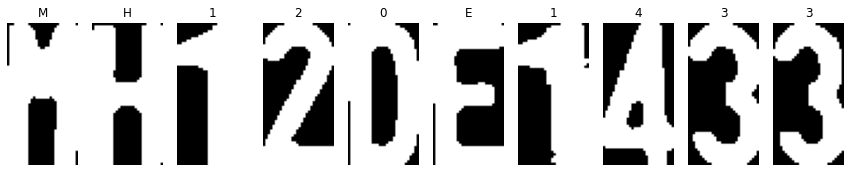

In [20]:
fig = plt.figure(figsize=(15,3))
cols = len(crop_characters)
grid = gridspec.GridSpec(ncols=cols,nrows=1,figure=fig)

final_string = ''
for i,character in enumerate(crop_characters):
    fig.add_subplot(grid[i])
    title = np.array2string(predict_from_model(character,cnn_model,labels))
    plt.title('{}'.format(title.strip("'[]"),fontsize=20))
    final_string+=title.strip("'[]")
    plt.axis(False)
    plt.imshow(character,cmap='gray')

print("Achieved result: ", final_string)
plt.savefig(final_string+'.png', dpi=300)

In [21]:
#![title](resources/images/2361BYR.png)

# General Solution for n License Plates

In [27]:
numsy = []
for p in range(len(plaquitas_list)):
    # python considers any number greater tahn 0 as a true~ish value, thus no need to put >=
    # Scales, calculates absolute values, and converts the result to 8-bit.
    plate_image = cv2.convertScaleAbs(plaquitas_list[p][0], alpha=(255.0))
    # convert to grayscale and blur the image
    gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    # Blur technique is performed to remove noise
    blur = cv2.GaussianBlur(gray,(5,5),0)
    # Applied inversed thresh_binary 
    binary = cv2.threshold(blur, 100, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    ## Applied dilation to increase the white region of the image
    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)

    cont, _  = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # creat a copy version "test_roi" of plat_image to draw bounding box
    test_roi = plate_image.copy()

    # Initialize a list which will be used to append charater image
    crop_characters = []

    # define standard width and height of character
    digit_w, digit_h = 30, 60

    for c in sort_contours(cont):
        (x, y, w, h) = cv2.boundingRect(c)
        ratio = h/w
        if 1<=ratio<=4.5: # Only select contour with defined ratio

            if h/plate_image.shape[0]>=0.5: # Select contour which has the height larger than 50% of the plate
                # Draw bounding box arroung digit number
                cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)

                # Seperate number and give prediction
                curr_num = thre_mor[y:y+h,x:x+w]
                curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
                _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                crop_characters.append(curr_num)
    if len(crop_characters) > 3:
        numsy.append(crop_characters)
        print("Detected {} letters...".format(len(crop_characters)))  

Detected 5 letters...
Detected 8 letters...
Detected 10 letters...
Detected 4 letters...
Detected 10 letters...
Detected 7 letters...
Detected 7 letters...
Detected 5 letters...
Detected 6 letters...
Detected 8 letters...
Detected 7 letters...
Detected 7 letters...
Detected 5 letters...
Detected 10 letters...
Detected 4 letters...
Detected 10 letters...


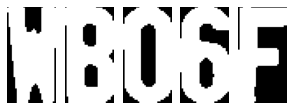

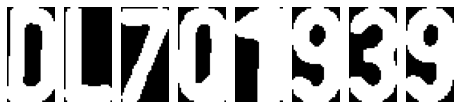

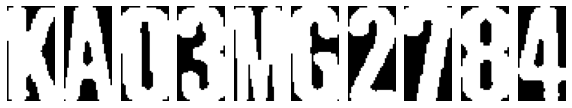

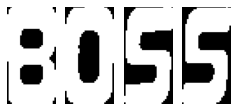

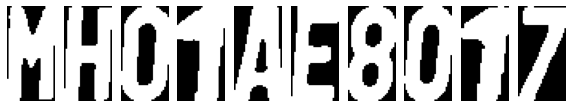

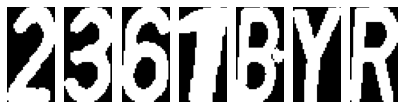

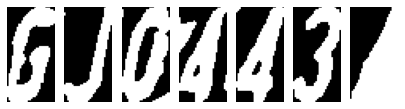

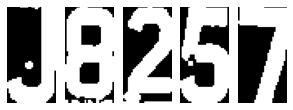

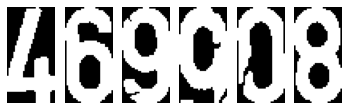

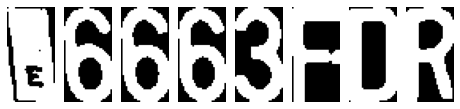

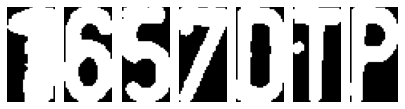

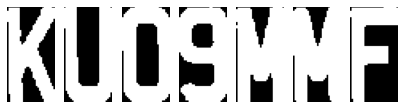

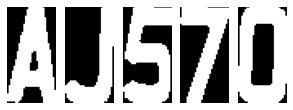

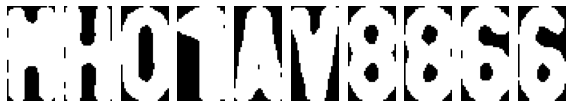

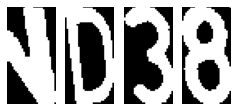

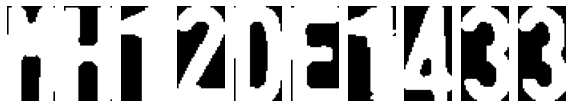

In [28]:
# printing all license plates only to visualize them before prediction
for n in range(len(numsy)):
    fig = plt.figure(figsize=(len(numsy[n]),3))
    grid = gridspec.GridSpec(ncols=len(numsy[n]),nrows=1,figure=fig)

    for i in range(len(numsy[n])):
        fig.add_subplot(grid[i])
        plt.axis(False)
        plt.imshow(numsy[n][i],cmap="gray")

## Prediction for n plates

Achieved result:  V806F
Achieved result:  0L701939
Achieved result:  R003MG228D
Achieved result:  BO55
Achieved result:  MH01LE8017
Achieved result:  2961BYR
Achieved result:  EJ0U43A
Achieved result:  98Z57
Achieved result:  469C08
Achieved result:  P6663F0R
Achieved result:  16570TP
Achieved result:  KU09MMF
Achieved result:  0557D
Achieved result:  MH01AV886G
Achieved result:  Q038
Achieved result:  MH120E1433


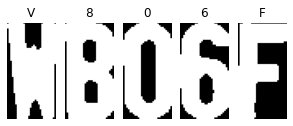

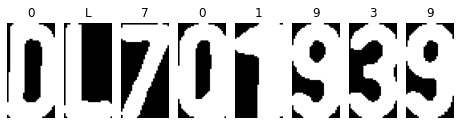

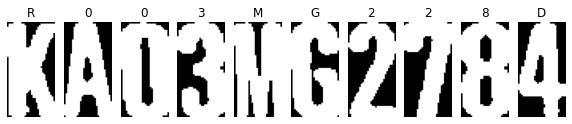

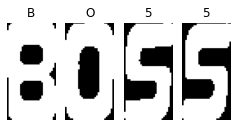

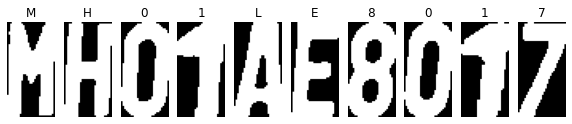

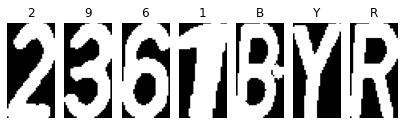

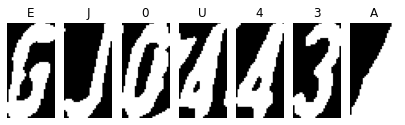

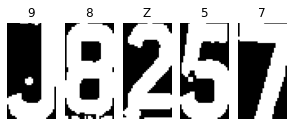

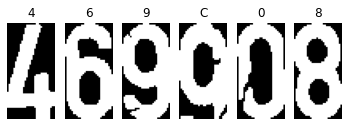

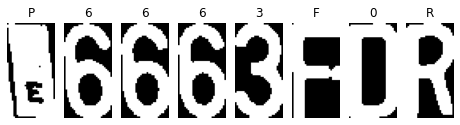

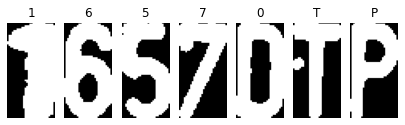

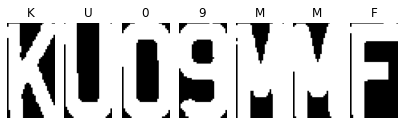

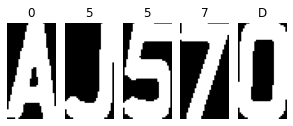

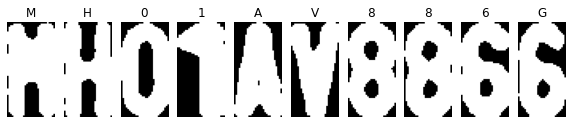

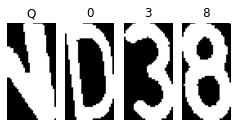

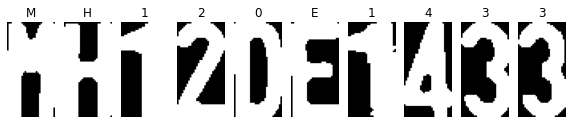

In [38]:
for n in range(len(numsy)):
    fig = plt.figure(figsize=(len(numsy[n]),3))
    grid = gridspec.GridSpec(ncols=len(numsy[n]),nrows=1,figure=fig)
    final_string = ''
    for i,character in enumerate(numsy[n]):
        fig.add_subplot(grid[i])
        title = np.array2string(predict_from_model(character,cnn_model,labels))
        plt.title('{}'.format(title.strip("'[]"),fontsize=40))
        final_string+=title.strip("'[]")
        plt.axis(False)
        plt.imshow(character,cmap='gray')

    print("Achieved result: ", final_string)
    plt.savefig(final_string+'.png', dpi=300)